In [1]:
# Import required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # Import tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
warnings.simplefilter('ignore')
# warnings.resetwarnings() # Re-open the simple warning instead of suppressing it

# Specify the font and font size to use
plt.rcParams['font.sans-serif'] = ['SimSun']  # Specify SimSun font
plt.rcParams['font.size'] = 12  # Specify font size

In [3]:
def read_csv_file(file_name, index_col = 0):
    current_dir = os.getcwd()
    file_path = os.path.join(current_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    return pd.read_csv(file_path, index_col = index_col)

try:
    df_raw_train = read_csv_file('train.csv')
    df_raw_test = read_csv_file('X_test.csv')

    print("raw train data:", df_raw_train.shape)
    print("test data:", df_raw_test.shape)

    X_train = df_raw_train.drop('label', axis=1)
    y_train = df_raw_train['label'].values.reshape(-1, 1)

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unknown error occurred: {e}")

raw train data: (11000, 26)
test data: (2100, 25)
X_train shape: (11000, 25)
y_train shape: (11000, 1)


In [4]:
Fraud_ratio = df_raw_train[df_raw_train['label'] == 1].shape[0]/df_raw_train.shape[0]
print(f"The Fraud_ratio is {Fraud_ratio}")
print(f"The Fraud number is {df_raw_train[df_raw_train['label'] == 1].shape[0]}")

The Fraud_ratio is 0.09090909090909091
The Fraud number is 1000


In [5]:
# Calculate fraud statistics for training data
df_with_fraud = df_raw_train[df_raw_train['cano'].isin(df_raw_train[df_raw_train['label'] == 1]['cano'].unique())]
df_with_fraud2 = df_with_fraud.groupby('cano')['label'].agg(fraud_count='sum', total_count='size').reset_index()
df_with_fraud2['ratio'] = df_with_fraud2['fraud_count']/df_with_fraud2['total_count']
print(f'Total records of cards with fraud experience: {df_with_fraud.shape}')
print(f'Total cards with fraud experience: {df_with_fraud2.shape}')
df_with_fraud2.head()

Total records of cards with fraud experience: (2567, 26)
Total cards with fraud experience: (731, 4)


,cano,fraud_count,total_count,ratio
0,00757fafb1856b35797405c7125dfb3a2a25333d432ba9...,1,1,1.0
1,0088c019c076f46d6d02ad92f88b868d06bdf176756bfd...,1,1,1.0
2,00e9f2e8467b425ee3b3eb0ce767ebb99b70a510b440f5...,1,1,1.0
3,010482e4160d45ca0040bdc49a8b14c69f1f08fae3c6cc...,1,1,1.0
4,0115d48817f7d91450a32b8a60b06eaa667eccfebffa42...,3,3,1.0


Text(0, 0.5, 'Frequency')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun
findfont: Generic family 'sans-serif' not foun

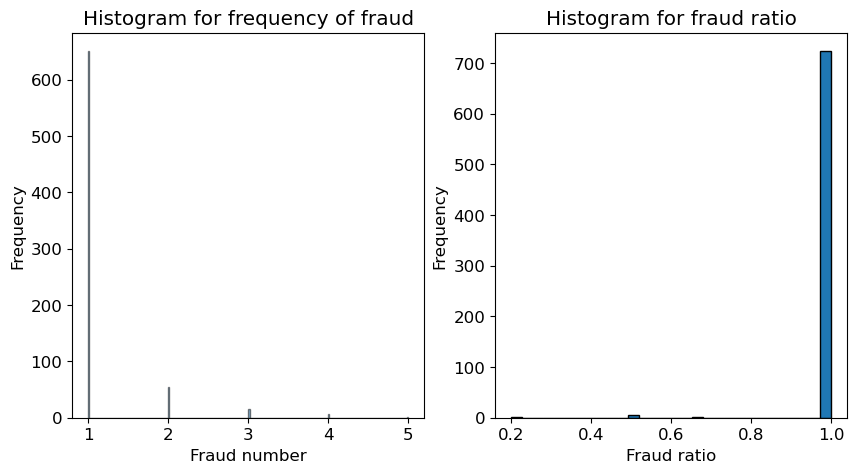

In [6]:
# Plot fraud statistics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df_with_fraud2['fraud_count'], bins=250, alpha=0.5, label='Data 1', edgecolor='black')
plt.title('Histogram for frequency of fraud')
plt.xlabel('Fraud number')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_with_fraud2['ratio'], bins=30, alpha=1, label='Data 2', edgecolor='black')
plt.title('Histogram for fraud ratio')
plt.xlabel('Fraud ratio')
plt.ylabel('Frequency')

In [7]:
# Remove explanatory variables that do not contribute to modeling
df_raw_train = df_raw_train.drop(['bnsfg','iterm','flbmk','insfg','flam1'],
                                 axis = 1,
                                 inplace = False
                                 )

df_raw_test = df_raw_test.drop(['bnsfg','iterm','flbmk','insfg','flam1'],
                               axis = 1,
                               inplace = False
                               )

In [8]:
# Calculate the difference between current consumption and average past consumption
df_raw_train['avg_conam'] = df_raw_train.groupby('cano')['conam'].transform('mean')
df_raw_train['diff_conam'] = df_raw_train['conam'] - df_raw_train['avg_conam']

# Check if it's the first appearance of the city for this card
df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'scity'])['locdt'].transform('min')
df_raw_train['is_city_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

# Check if it's the first appearance of the currency for this card
df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_raw_train['is_csmcu_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

# Calculate total number of transactions, if it's the first transaction, and daily transaction frequency
df_raw_train['cano_count'] = df_raw_train.groupby('cano')['cano'].transform('count')
df_raw_train['Is_First_Occurrence'] = ~df_raw_train['cano'].duplicated()
df_raw_train['freq_perday'] = df_raw_train.groupby(['cano','locdt'])['cano'].transform('count')

In [9]:
# Fill NA values
df_raw_train['etymd'] = df_raw_train['etymd'].fillna(99)
df_raw_train['stscd'] = df_raw_train['stscd'].fillna(99)
df_raw_train['stocn'] = df_raw_train['stocn'].fillna(999)
df_raw_train['hcefg'] = df_raw_train['hcefg'].fillna(999)
df_raw_train['csmcu'] = df_raw_train['csmcu'].fillna(999)
df_raw_train['scity'] = df_raw_train['scity'].fillna(999)
df_raw_train['mcc'] = df_raw_train['mcc'].fillna(999)

In [10]:
# Create dictionary for label encoding
label_encoder = LabelEncoder()

X = df_raw_train.drop(['txkey','locdt','label','chid'],
                      axis = 1,
                      inplace = False
                      )

Y = df_raw_train[['label']]

dict_mchno = dict(zip(X['mchno'], 
                      label_encoder.fit_transform(X['mchno']))
                      )

dict_acqic = dict(zip(X['acqic'], 
                      label_encoder.fit_transform(X['acqic']))) 

dict_cano = dict(zip(X['cano'], 
                     label_encoder.fit_transform(X['cano']))
                     )
 
X['mchno'] = label_encoder.fit_transform(X['mchno'])
X['acqic'] = label_encoder.fit_transform(X['acqic'])
X['cano'] = label_encoder.fit_transform(X['cano'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.1, 
                                                    random_state = 42
                                                    )


In [11]:
# LightGBM
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

lgb_train = lgb.Dataset(X_train, label = y_train)
lgb_eval = lgb.Dataset(X_test, label = y_test, reference = lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
bst = lgb.train(params, lgb_train, num_round, valid_sets = [lgb_train, lgb_eval], callbacks=[lgb.early_stopping(stopping_rounds = 200)])

[LightGBM] [Info] Number of positive: 876, number of negative: 9024
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 9900, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088485 -> initscore=-2.332277
[LightGBM] [Info] Start training from score -2.332277
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0625518	valid_1's binary_logloss: 0.132722


In [12]:
# Random Forest
y_train = y_train.astype(dtype = 'category')
y_test = y_test.astype(dtype = 'category')

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 42, 
                                       n_jobs = 12
                                       )

rf_classifier.fit(X_train, y_train)

/usr/lib/python3/dist-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=42)

In [13]:
# XGBoost
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

xgb_model = xgb.XGBClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    gamma = 0,
    subsample = 0.8,
    max_depth = 5,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    n_jobs = 12,
    scale_pos_weight = 1,
    seed = 42,
    enable_categorical = True,
    tree_method = 'hist'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=12,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
# Integrated all the result 
y_probabilities_xgb_train = xgb_model.predict_proba(X_test)[:,1]
y_probabilities_lgbm_train = bst.predict(X_test, num_iteration=bst.best_iteration)
y_probabilities_rf_train = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

y_probabilities = (y_probabilities_rf_train + y_probabilities_lgbm_train + y_probabilities_xgb_train)/3

print(y_probabilities)

/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-

[0.00370331 0.00146718 0.89169989 ... 0.00547228 0.00179435 0.0606806 ]


/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/lib/python3/dist-

In [20]:
predictions = (y_probabilities >= 0.36).astype(int)
print(predictions.shape)
df_raw_test['pred'] = predictions

(1100,)


ValueError: Length of values (1100) does not match length of index (2100)

In [ ]:
predictions = (y_probabilities >= 0.36).astype(int)
df_raw_test['pred'] = predictions